In [231]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

In [232]:
import myModule.simulation as myModule
import myModule.halo as halo
import myModule.gas as gas
import myModule.chandrasekhar as chandra
import myModule.accretion as accretion

In [233]:
## Units
# Mass:     10**6 Solar Masses
# Distance: Parsecs
# Time:     10**6 Years (Myr)

G = 4490.0
v_s = 9.198           # Speed of sound in the gas 
m_init = 2            # Initial mass of the black hole
m_tot = m_init+1e5    # Total mass of the galaxy
tau = 50              # Salpeter Timescale

In [234]:
def m_dot(r,v,m):
    if m < m_tot:
        return min(4*np.pi*(m_tot-m)*gas.density(r)*G*G*m*m*(v_s*v_s+np.sum(v*v))**-1.5,m/tau)
    return 0

In [235]:
mySim = myModule.simulation()

haloGravity = myModule.interaction('Halo Gravity', halo.acceleration)
gasGravity = myModule.interaction('Gas Gravity', gas.acceleration)
dynFriction = myModule.interaction('Dynamical Friction', chandra.acceleration, rho = gas.density)
massAccretion = myModule.interaction('Mass Accretion', accretion.acceleration, m_dot = m_dot)

mySim.interactions.append(haloGravity)
mySim.interactions.append(gasGravity)
mySim.interactions.append(dynFriction)
mySim.interactions.append(massAccretion)

mySim.updateDerivatives()

In [236]:
t_init = 0
t_final = 100
n_steps = 1000

t = np.linspace(t_init,t_final,n_steps)

r_init = np.array([2e3,0,0])
v_init = np.array([0,200,0])
m_init = m_init*np.ones(1)

s_init = np.concatenate((r_init, v_init, m_init))

In [237]:
mySim.integrate(t_init, t_final, n_steps, s_init)

TypeError: 'numpy.float64' object is not iterable

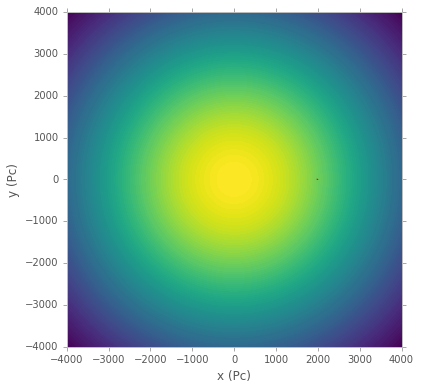

In [230]:
def density(x,y,z, a = 6.5e3, b = 0.26e3, M = 1e5):
    R2 = x*x+y*y+z*z
    rho = M*b*b*(a*R2+(a+3*(z*z+b*b)**.5)*(a+(z*z+b*b)**.5)**2)
    rho /=4*np.pi*((R2+(a+(z*z+b*b)**.5)**2)**2.5)*((z*z+b*b)**1.5)
    return rho

x = np.linspace(-4e3,4e3,1e2)
y = np.linspace(-4e3,4e3,1e2)
X,Y = np.meshgrid(x,y)
rho = density(X,Y,0)
plt.plot(mySim.path[:,0],mySim.path[:,1],'r',lw=1)
plt.contourf(X,Y,rho, levels=np.linspace(np.min(rho),np.max(rho),100), cmap='viridis')
plt.xlabel('x (Pc)')
plt.ylabel('y (Pc)')

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':


/usr/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


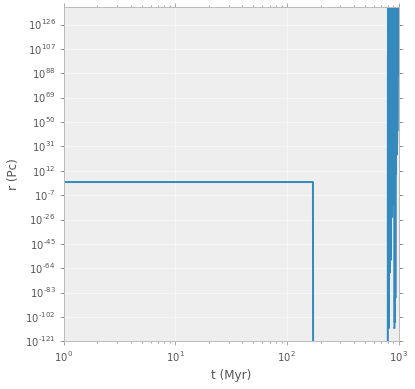

In [220]:
plt.plot(t,np.sum(mySim.path[:,:3]**2,axis=1)**.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (Myr)')
plt.ylabel('r (Pc)')

/usr/lib/python3.5/site-packages/matplotlib/ticker.py:1593: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
/usr/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


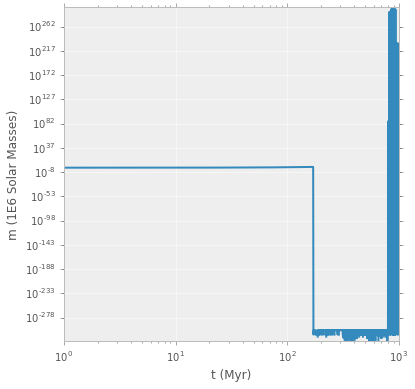

In [221]:
plt.plot(t,mySim.path[:,6])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (Myr)')
plt.ylabel('m (1E6 Solar Masses)')

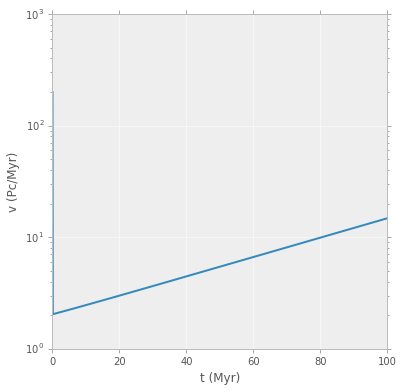

In [216]:
plt.plot(t,np.sum(mySim.path[:,3:7]**2,axis=1)**.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (Myr)')
plt.ylabel('v (Pc/Myr)')